## Estimated Ultimate Gas Recovery Prediction Using ML


EUR, or Estimated Ultimate Recovery, is a term used in the shale gas industry to refer to the estimated total amount of natural gas that can be economically recovered from a well. It is a prediction based on a variety of factors, such as the size of the reservoir, the quality of the rock, and the expected decline rate of production over time. EUR is an important metric for evaluating the potential economic value of a shale gas well and is often used in decision making for investment and development. In a shale gas wells dataset, EUR values would typically be associated with individual wells and may be used for comparison and analysis purposes

In this project, we are going to fit a machine learning model with the features of Shale Gas well to predict the estimated ultimate recovery (EUR).

### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge,LinearRegression
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,BaggingRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

In [2]:
# Get the data

data  = pd.read_csv('Shale_Gas_Wells_Dataset.csv')

In [3]:
data.head().style.background_gradient(cmap='Blues')

,Stage Spacing,bbl/ft,Well Spacing,Dip,Thickness,Lateral Length,Injection Rate,Porosity,ISIP,Water Saturation,Percentage of LG,Pressure Gradient,Proppant Loading,EUR
0,140,38,850,0,165,8543,64,8.300000,8200,17.100000,38.000000,0.950000,3012,13.300000
1,140,30,900,0,174,8336,60,7.800000,8061,16.000000,59.300000,0.950000,2771,12.500000
2,140,30,900,0,174,9361,65,7.800000,8061,16.000000,59.300000,0.950000,3067,16.900000
3,140,30,950,0,175,9110,69,8.300000,7922,15.700000,66.900000,0.950000,3130,16.500000
4,140,30,950,0,175,9310,67,8.300000,7922,15.700000,66.900000,0.950000,2991,17.400000


In [4]:
# Check missing values
data.isna().sum()

Stage Spacing        0
bbl/ft               0
Well Spacing         0
Dip                  0
Thickness            0
Lateral Length       0
Injection Rate       0
Porosity             0
ISIP                 0
Water Saturation     0
Percentage of LG     0
Pressure Gradient    0
Proppant Loading     0
EUR                  0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Stage Spacing      506 non-null    int64  
 1   bbl/ft             506 non-null    int64  
 2   Well Spacing       506 non-null    int64  
 3   Dip                506 non-null    int64  
 4   Thickness          506 non-null    int64  
 5   Lateral Length     506 non-null    int64  
 6   Injection Rate     506 non-null    int64  
 7   Porosity           506 non-null    float64
 8   ISIP               506 non-null    int64  
 9   Water Saturation   506 non-null    float64
 10  Percentage of LG   506 non-null    float64
 11  Pressure Gradient  506 non-null    float64
 12  Proppant Loading   506 non-null    int64  
 13  EUR                506 non-null    float64
dtypes: float64(5), int64(9)
memory usage: 55.5 KB


In [6]:
data.shape

(506, 14)

In [10]:
# check duplicate
duplicate = data.duplicated()
print(duplicate.sum())

0


### Descriptive Statistics

In [8]:
data.describe().style.background_gradient(cmap='coolwarm')

,Stage Spacing,bbl/ft,Well Spacing,Dip,Thickness,Lateral Length,Injection Rate,Porosity,ISIP,Water Saturation,Percentage of LG,Pressure Gradient,Proppant Loading,EUR
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,147.640316,35.134387,820.158103,0.069170,162.365613,8153.086957,63.079051,7.337549,7010.490119,19.213439,64.845455,0.930257,2567.065217,12.845455
std,18.392128,10.533197,135.736986,0.253994,15.471044,942.393981,7.250106,0.749451,1211.452205,3.198579,18.427813,0.046507,413.792220,3.067064
min,140.000000,30.000000,650.000000,0.000000,120.000000,4500.000000,55.000000,5.500000,5000.000000,15.000000,15.000000,0.750000,1100.000000,7.000000
25%,140.000000,30.000000,700.000000,0.000000,153.000000,7617.750000,57.000000,6.600000,5000.000000,16.800000,55.900000,0.940000,2317.500000,11.000000
50%,141.000000,30.000000,800.000000,0.000000,165.000000,8051.000000,61.000000,7.500000,7643.000000,17.700000,69.900000,0.950000,2642.000000,12.400000
75%,148.000000,36.000000,900.000000,0.000000,176.000000,8608.000000,69.000000,8.000000,7783.000000,24.100000,79.700000,0.950000,2897.750000,13.700000
max,330.000000,75.000000,1350.000000,1.000000,185.000000,11500.000000,80.000000,8.500000,8200.000000,25.000000,95.000000,0.950000,3200.000000,22.000000


### Visualize the dataset 

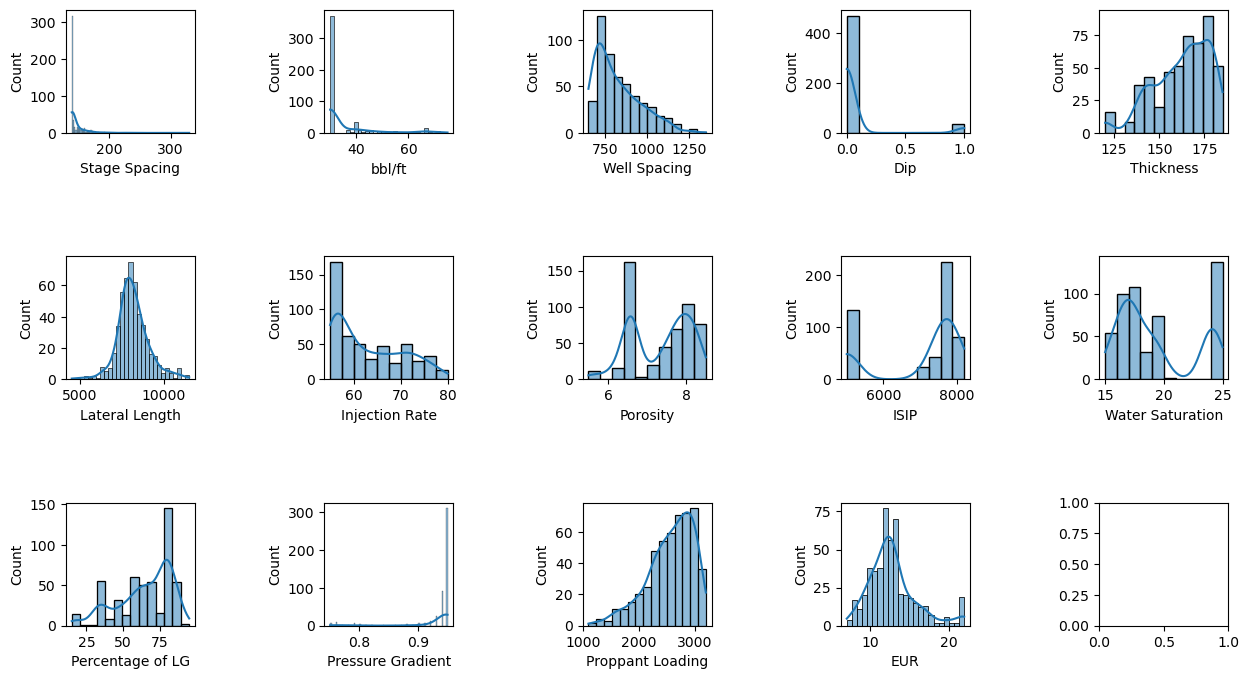

In [28]:
# Histogram of the columns in the dataset 
num_col = data.select_dtypes(exclude="object").columns
fig,ax =plt.subplots(3,5, figsize=(15,8))

for idx, num_col in enumerate(num_col):
    row, col = idx //5, idx % 5
    sns.histplot(x=num_col, data=data,kde=True, ax=ax[row,col])
    plt.interactive(True)
    
plt.subplots_adjust(hspace=1,wspace=1)
plt.show()

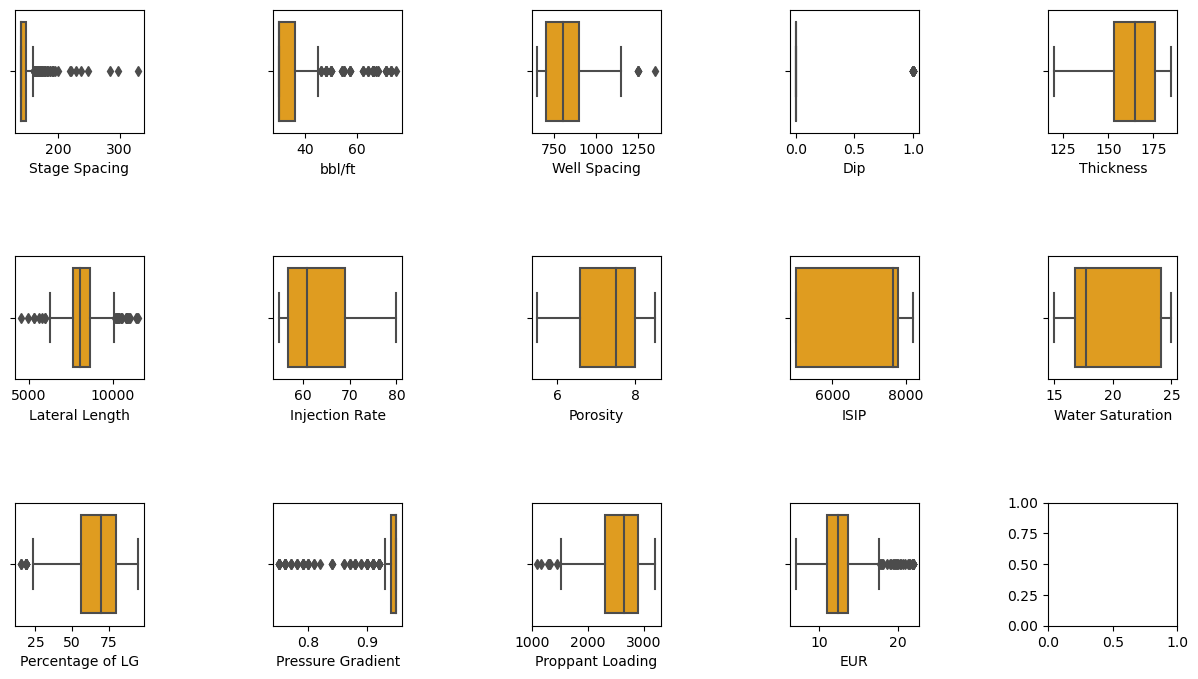

In [32]:
# boxplot of the columns in the dataset 
num_col = data.select_dtypes(exclude="object").columns
fig,ax =plt.subplots(3,5, figsize=(15,8))

for idx, num_col in enumerate(num_col):
    row, col = idx //5, idx % 5
    sns.boxplot(x=num_col, data=data, ax=ax[row,col],color='orange')
    plt.interactive(True)
    
plt.subplots_adjust(hspace=1,wspace=1)
plt.show()

- There are a lot of outliers in most of the feature columns

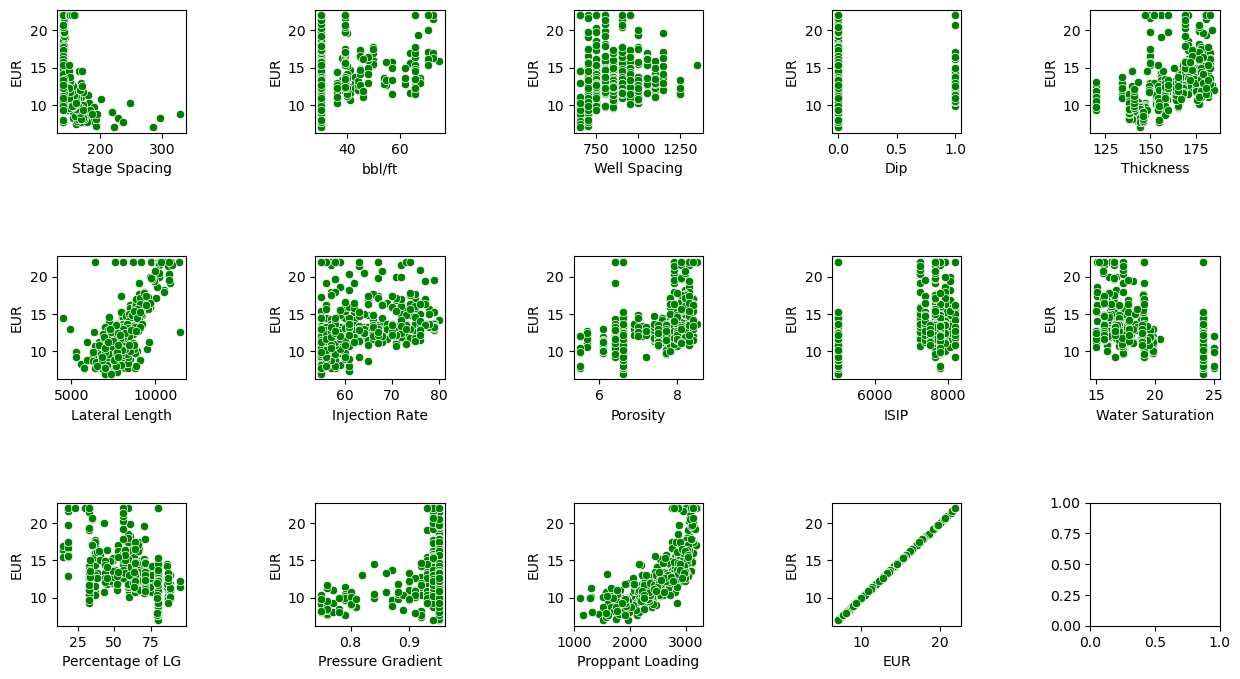

In [34]:
# scatterplot of the columns in the dataset 
num_col = data.select_dtypes(exclude="object").columns
fig,ax =plt.subplots(3,5, figsize=(15,8))

for idx, num_col in enumerate(num_col):
    row, col = idx //5, idx % 5
    sns.scatterplot(x=num_col,y='EUR', data=data, ax=ax[row,col],color='green')
    plt.interactive(True)
    
plt.subplots_adjust(hspace=1,wspace=1)
plt.show()

- Only a few of the features have some relationship with the target EUR

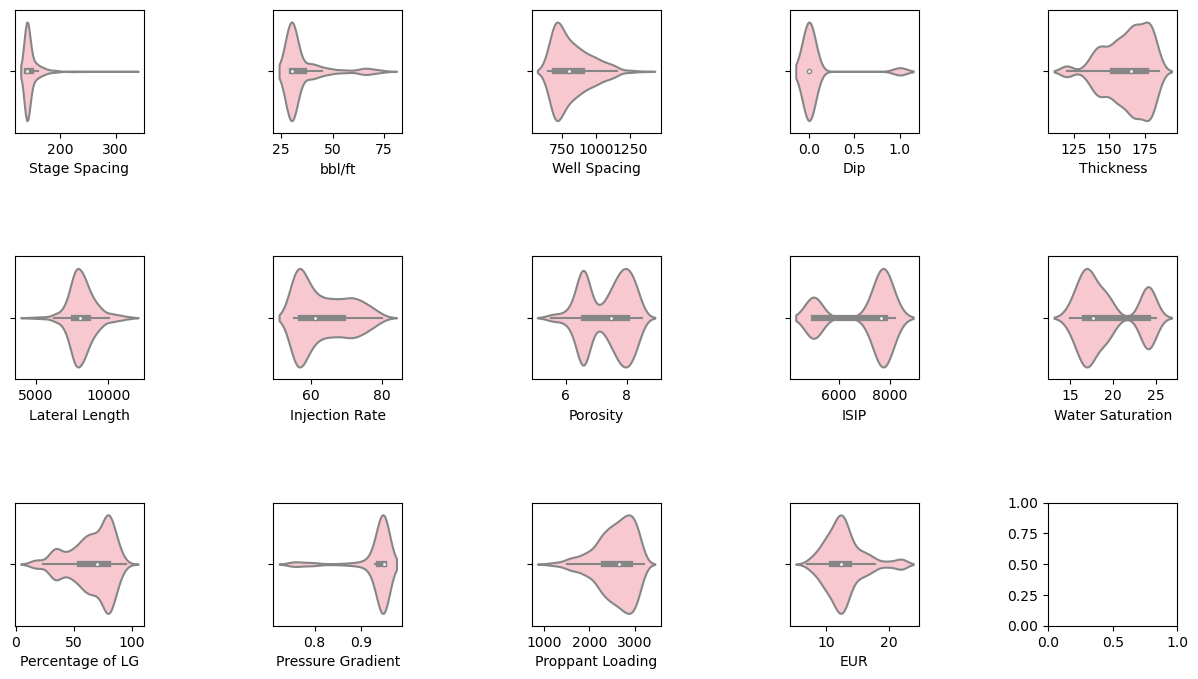

In [36]:
# violinplot of the columns in the dataset 
num_col = data.select_dtypes(exclude="object").columns
fig,ax =plt.subplots(3,5, figsize=(15,8))

for idx, num_col in enumerate(num_col):
    row, col = idx //5, idx % 5
    sns.violinplot(x=num_col, data=data, ax=ax[row,col],color='pink')
    plt.interactive(True)
    
plt.subplots_adjust(hspace=1,wspace=1)
plt.show()

## Correlation between variables

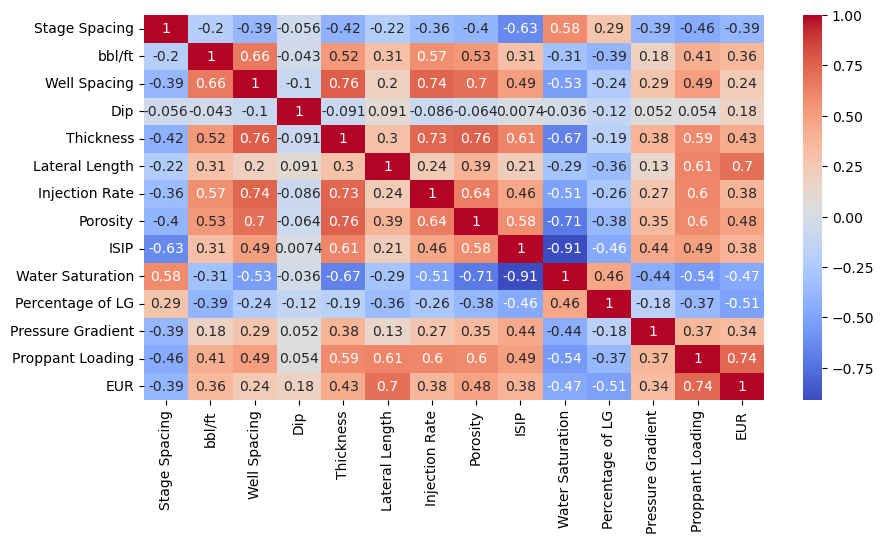

In [37]:
data_corr = data.corr()
plt.figure(figsize=(10,5))
sns.heatmap(data_corr, annot=True, cmap='coolwarm')
plt.show()

## How does the target variable EUR correlates with the other variable

<Axes: >

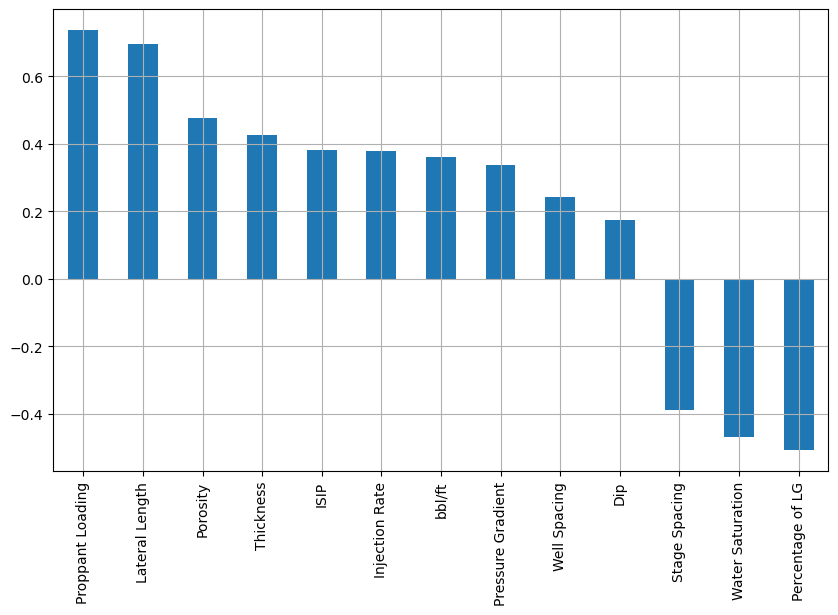

In [38]:
data_corr['EUR'][:-1].sort_values(ascending=False).plot(kind='bar', grid=True,figsize=(10,6))

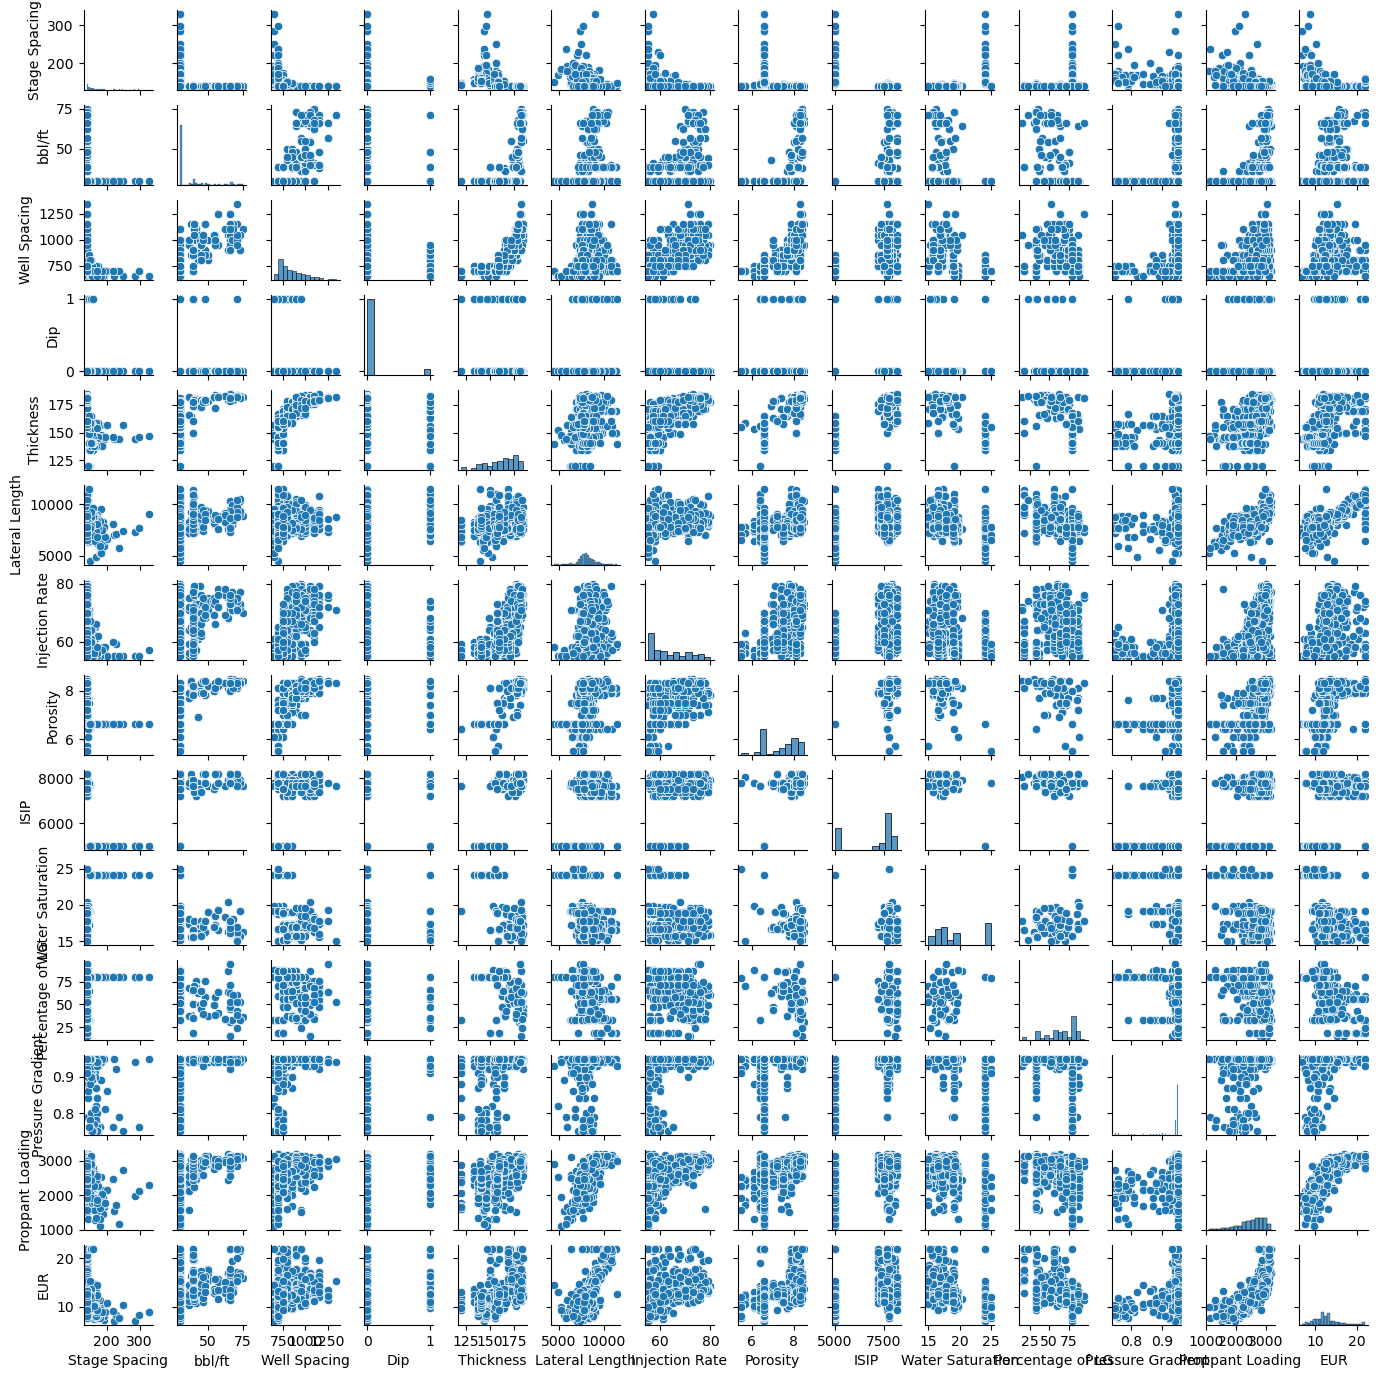

In [39]:
sns.pairplot(data,palette='viridis',height=1)
plt.interactive(True)
plt.show()

### Remove outliers and Standardize the data

In [40]:
# remove outlier function
def remove_outlier(data):
    for col in data.columns:
        q1,q3 = data[col].quantile([0.25,0.75])
        iqr = q3-q1
        lower = q1-1.5*iqr
        upper = q3+1.5*iqr
        data[col] =np.where(data[col]<lower,lower,data[col])
        data[col] = np.where(data[col]>upper,upper,data[col])
        return data

In [41]:
data = remove_outlier(data)

In [42]:
# X = features
# Y = target
X = data.iloc[:,:-1]
Y = data.iloc[:,-1]

In [43]:
X.head()

,Stage Spacing,bbl/ft,Well Spacing,Dip,Thickness,Lateral Length,Injection Rate,Porosity,ISIP,Water Saturation,Percentage of LG,Pressure Gradient,Proppant Loading
0,140.0,38,850,0,165,8543,64,8.3,8200,17.1,38.0,0.95,3012
1,140.0,30,900,0,174,8336,60,7.8,8061,16.0,59.3,0.95,2771
2,140.0,30,900,0,174,9361,65,7.8,8061,16.0,59.3,0.95,3067
3,140.0,30,950,0,175,9110,69,8.3,7922,15.7,66.9,0.95,3130
4,140.0,30,950,0,175,9310,67,8.3,7922,15.7,66.9,0.95,2991


In [44]:
Y.head()

0    13.3
1    12.5
2    16.9
3    16.5
4    17.4
Name: EUR, dtype: float64

## Train Test split

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [46]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

In [47]:
# scale the data
scaler =StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Building Models

In [49]:
# model evaluation function
def evaluate_model(true,pred):
    print('='*35)
    mae = print('MAE:',mean_absolute_error(true,pred))
    mse = print("MSE:",mean_squared_error(true,pred))
    rmse = print("RMSE:",np.sqrt(mean_squared_error(true,pred)))
    r2 =print("R2_Score:",r2_score(true,pred))
    
    return

### LinearRegression

Train_score: 0.7499844184100681
Test_score: 0.6580725183771918
MAE: 1.084931657073681
MSE: 2.7781578303351298
RMSE: 1.6667806785342605
R2_Score: 0.6580725183771918


,Actual values,Predicted values
173,13.2,14.993023
274,16.1,17.279260
491,9.9,10.343401
72,12.9,13.800056
452,10.7,11.386439
...,...,...
412,11.3,5.032974
436,8.5,9.765092
411,11.1,10.333422
86,12.8,12.813370


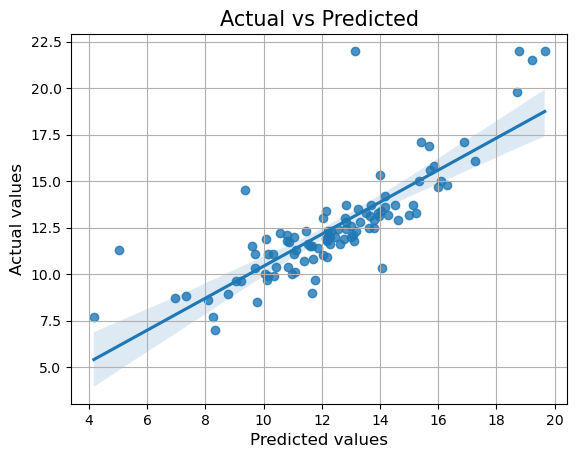

In [140]:

lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
y_pred =lr_model.predict(x_test)

print('Train_score:',lr_model.score(x_train,y_train))
print('Test_score:',lr_model.score(x_test,y_test))
evaluate_model(y_test,y_pred)


sns.regplot(x=y_pred,y=y_test,data=data)
plt.xlabel('Predicted values', size=12)
plt.ylabel('Actual values', size=12)
plt.title('Actual vs Predicted', size=15)
plt.grid()

pd.DataFrame(data={'Actual values':y_test,'Predicted values':y_pred})

### RandomForestRegressor

Train_score: 0.866376390878619
Test_score: 0.8279085729748722
MAE: 0.8412579199025921
MSE: 1.3982413558989988
RMSE: 1.1824725603154598
R2_Score: 0.8279085729748722


,Actual values,Predicted values
173,13.2,12.955835
274,16.1,15.338793
491,9.9,10.853276
72,12.9,13.410718
452,10.7,10.830359
...,...,...
412,11.3,9.307837
436,8.5,9.847248
411,11.1,9.395123
86,12.8,12.492167


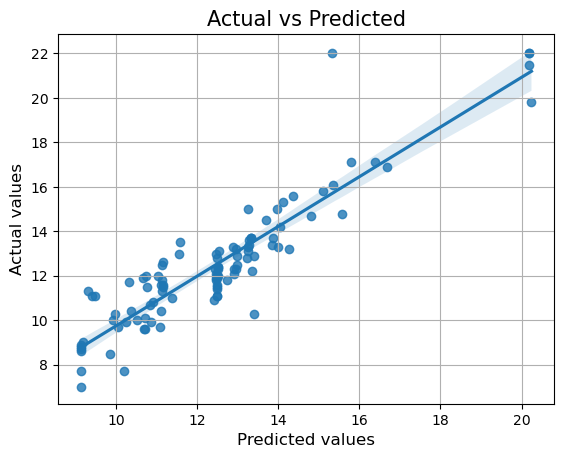

In [139]:
rf_model = RandomForestRegressor(criterion="poisson",max_depth=3)
rf_model.fit(x_train,y_train)
y_pred =rf_model.predict(x_test)

print('Train_score:',rf_model.score(x_train,y_train))
print('Test_score:',rf_model.score(x_test,y_test))
evaluate_model(y_test,y_pred)

sns.regplot(x=y_pred,y=y_test,data=data)
plt.xlabel('Predicted values', size=12)
plt.ylabel('Actual values', size=12)
plt.title('Actual vs Predicted', size=15)
plt.grid()


pd.DataFrame(data={'Actual values':y_test,'Predicted values':y_pred})

### GradientBoostingRegressor

Train_score: 0.8636867853776935
Test_score: 0.8003353410234522
MAE: 0.9919463082281881
MSE: 1.6222736269815186
RMSE: 1.2736850580035548
R2_Score: 0.8003353410234522


,Actual values,Predicted values
173,13.2,14.480773
274,16.1,16.179613
491,9.9,11.903291
72,12.9,13.882794
452,10.7,11.732718
...,...,...
412,11.3,9.486032
436,8.5,10.791617
411,11.1,10.442221
86,12.8,12.908486


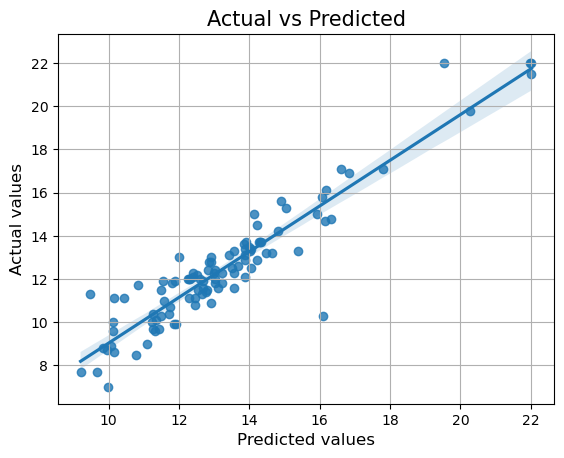

In [138]:
gb_model = GradientBoostingRegressor(max_depth=5,learning_rate=0.22,loss='quantile')
gb_model.fit(x_train,y_train)
y_pred =gb_model.predict(x_test)

print('Train_score:',gb_model.score(x_train,y_train))
print('Test_score:',gb_model.score(x_test,y_test))
evaluate_model(y_test,y_pred)

sns.regplot(x=y_pred,y=y_test,data=data)
plt.xlabel('Predicted values', size=12)
plt.ylabel('Actual values', size=12)
plt.title('Actual vs Predicted', size=15)
plt.grid()

pd.DataFrame(data={'Actual values':y_test,'Predicted values':y_pred})

### BaggingRegressor

Train_score: 0.9199202936531561
Test_score: 0.8726278852268333
MAE: 0.720712685479759
MSE: 1.0348973306970763
RMSE: 1.017299037007839
R2_Score: 0.8726278852268333


,Actual values,Predicted values
173,13.2,12.932341
274,16.1,15.737128
491,9.9,10.587683
72,12.9,12.732617
452,10.7,10.763658
...,...,...
412,11.3,9.246338
436,8.5,9.919072
411,11.1,9.937163
86,12.8,12.157244


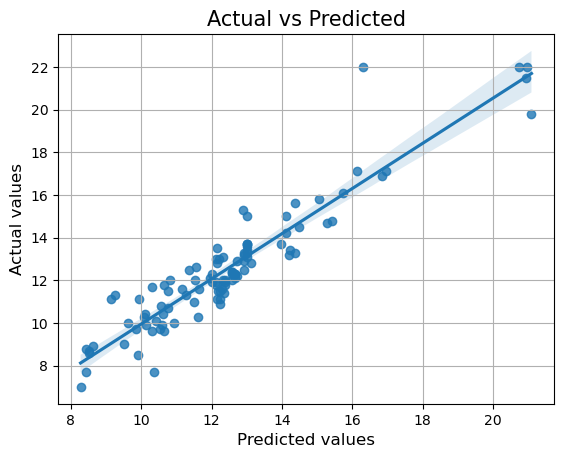

In [137]:
b_model = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=5,criterion="poisson"))
b_model.fit(x_train,y_train)
y_pred =b_model.predict(x_test)

print('Train_score:',b_model.score(x_train,y_train))
print('Test_score:',b_model.score(x_test,y_test))
evaluate_model(y_test,y_pred)

sns.regplot(x=y_pred,y=y_test,data=data)
plt.xlabel('Predicted values', size=12)
plt.ylabel('Actual values', size=12)
plt.title('Actual vs Predicted', size=15)
plt.grid()

pd.DataFrame(data={'Actual values':y_test,'Predicted values':y_pred})

### DecisionTreeRegressor

Train_score: 0.8894046178754903
Test_score: 0.8346743255357929
MAE: 0.8506476059011927
MSE: 1.3432696748687896
RMSE: 1.158995114255789
R2_Score: 0.8346743255357929


,Actual values,Predicted values
173,13.2,12.893056
274,16.1,14.645000
491,9.9,11.472000
72,12.9,12.893056
452,10.7,11.472000
...,...,...
412,11.3,10.713333
436,8.5,10.133333
411,11.1,10.713333
86,12.8,12.288636


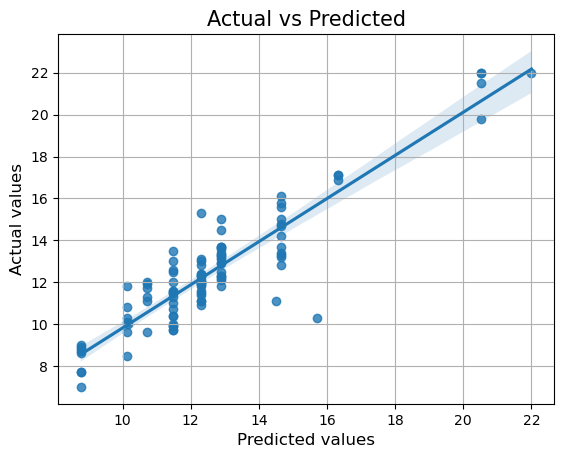

In [136]:
tree_model = DecisionTreeRegressor(criterion='poisson',max_depth=4)
tree_model.fit(x_train,y_train)
y_pred =tree_model.predict(x_test)

print('Train_score:',tree_model.score(x_train,y_train))
print('Test_score:',tree_model.score(x_test,y_test))
evaluate_model(y_test,y_pred)


sns.regplot(x=y_pred,y=y_test,data=data)
plt.xlabel('Predicted values', size=12)
plt.ylabel('Actual values', size=12)
plt.title('Actual vs Predicted', size=15)
plt.grid()

pd.DataFrame(data={'Actual values':y_test,'Predicted values':y_pred})

### Ridge

Train_score: 0.7499627771669232
Test_score: 0.6577464092030001
MAE: 1.0832859899843539
MSE: 2.780807464554423
RMSE: 1.6675753250016694
R2_Score: 0.6577464092030001


,Actual values,Predicted values
173,13.2,14.982285
274,16.1,17.265417
491,9.9,10.379498
72,12.9,13.799924
452,10.7,11.374433
...,...,...
412,11.3,5.031307
436,8.5,9.777076
411,11.1,10.335800
86,12.8,12.814106


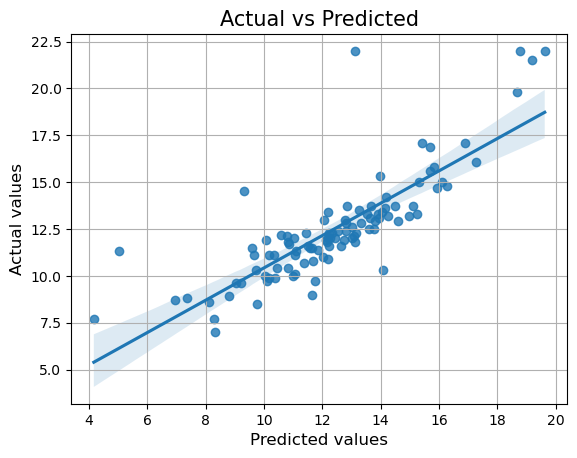

In [135]:
r_model = Ridge()
r_model.fit(x_train,y_train)
y_pred =r_model.predict(x_test)

print('Train_score:',r_model.score(x_train,y_train))
print('Test_score:',r_model.score(x_test,y_test))
evaluate_model(y_test,y_pred)


sns.regplot(x=y_pred,y=y_test,data=data)
plt.xlabel('Predicted values', size=12)
plt.ylabel('Actual values', size=12)
plt.title('Actual vs Predicted', size=15)
plt.grid()


pd.DataFrame(data={'Actual values':y_test,'Predicted values':y_pred})